# Formulation Symbolic language

## Dependencies
FSL is based on "Formulate" library available at https://github.com/l0d0v1c/formulate and the local unit FSL.py

In [1]:
!pip install "https://github.com/l0d0v1c/formulate/blob/main/dist/formulate-1.3-py3-none-any.whl?raw=true"
!pip install pandas
!pip install openpyxl
# comment the lines above if installed
import pandas as pd
from formulate.components import components
from FSL import formulationsymboliclanguage

## Purpose
FSL is a language focused on formulation description and deep learning. A formulation is a list of ingredients and quantities. FSL transforms this recipe in a string inspired by SMILES language used to represent molecules. These strings may be used for instance to train a deep auto encoder and generate new formulations from existing ones
## Encoding process
Ingredients can be either major or minor. Major components are the ones usually present in significant amount, minor ones are usually additives used to modify properties of the formulation, like colouring or viscosity agents. Major ingredients are encoded in latin alphabet and minor one is greek. To be included in FSL each FORMULATE object must embed a minor <True|False> property.
### Example
Considering Air as Oxygen/Nitrogen major ingredients and a minor water additive

In [2]:
c=components(physical={"∆Hf":True,"rho":None,"minor":None})
c.add("Water","H2O",{'∆Hf':-285.83,"rho":1.0,'minor':True})
c.add("Nitrogen","N2",{'∆Hf':0,"rho":0.01,'minor':False})
c.add("Oxygen","O2",{'∆Hf':0,"rho":0.01,'minor':False})
c.setrates({"Water":0.01,"Oxygen":0.19,'Nitrogen':0.8})
c.mixing()

,Component,Rate,N,O,H,∆Hf,rho,minor
0,Water,0.01,0.0000,55.50800,111.01700,-15865.9700,1.0,1
1,Nitrogen,0.80,71.3940,0.00000,0.00000,0.0000,0.01,0
2,Oxygen,0.19,0.0000,62.50200,0.00000,0.0000,0.01,0
3,Formulation,1.00,57.1152,12.43046,1.11017,-158.6597,Non additive,Non additive


We can now encode the air formulation as

In [3]:
from IPython.display import display, HTML
f=formulationsymboliclanguage([c])
e=f.encode([c])
display(HTML(f"<span style='font-size:3em'>{e[0]}</span>"))

The dictionary of ingredients is

In [4]:
f.dict

{'Water': 'α', 'Nitrogen': 'A', 'Oxygen': 'B'}

### Formulation list with several quantities
To train an autoencoder we need a list of formulations having the same ingredients at several quantities. During the FSL initialisation process you can define a "dose". In formulation recipes, the quantity of each component is often given in units (oz, parts..). FSL use the same representation:

    formulationsymboliclanguage(formulae,granulo=5)

means for each ingredient the delta between the maximum and the minimum quantity is splitted in 5 doses. So CCCD means 3 doses of C and one of D. Minor components are only represented by one letter.

Let's try encoding a recipes book of cocktails

In [5]:
import pandas as pd
df=pd.read_excel("cocktails.xlsx")
df.head()

,Unnamed: 0,nom,categ,i1,d1,i2,d2,i3,d3,i4,d4,i5,d5,i6,d6
0,0,Gauguin,Cocktail Classics,Light Rum,2.0,Passion Fruit Syrup,1.0,Lemon Juice,1.00,Lime Juice,1.00,NaN,NaN,NaN,NaN
1,1,Fort Lauderdale,Cocktail Classics,Light Rum,1.5,Sweet Vermouth,0.5,Juice of Orange,0.25,Juice of a Lime,0.25,NaN,NaN,NaN,NaN
2,2,Apple Pie,Cordials and Liqueurs,Apple schnapps,3.0,Cinnamon schnapps,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Cuban Cocktail No. 1,Cocktail Classics,Juice of a Lime,0.5,Powdered Sugar,0.5,Light Rum,2.00,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Cool Carlos,Cocktail Classics,Dark rum,1.5,Cranberry Juice,2.0,Pineapple Juice,2.00,Orange curacao,1.00,Sour Mix,1.0,NaN,NaN


Now we have to transform this sheet in a list of formulations. As many ingredients are only used a few times they are not usable for a deep learning training. So we can limit the major ingredients list to the ones uses in more than 30 recipes. The rare ingredients are represented as minors

In [6]:
from collections import Counter
ingredients=[]
for i in range(1,7):
    for j in df[f"i{i}"].tolist():
        ingredients.append(j)
ingredients=Counter(ingredients)
composant={}
for name,cnt in ingredients.items():
    if cnt>30:
        composant[name]={'minor':False}
print(f"based on {len(composant)} ingredients")
listcompo=[]
for i,j in df.iterrows():
    try:
        cp=components(physical={"minor":None})
        rates={}
        for k in range(1,7):
            if j[f"d{k}"]==j[f"d{k}"] and j[f"i{k}"]==j[f"i{k}"] : #not nan
                name=j[f"i{k}"]
                if name in composant:
                    rate=j[f"d{k}"]
                    cp.add(name,"",{'minor':False})
                    rates[name]=rate
                else:
                    cp.add(name,"",{'minor':True})
                    rates[name]=0.001
                    
        cp.setrates(rates)
        cp.mixing()
    except:
        pass
    listcompo.append(cp)

based on 23 ingredients


For instance we can inpect the first cocktail

In [7]:
listcompo[0].formulationlist

,Component,Rate,minor
0,Light Rum,0.666,0
1,Passion Fruit Syrup,0.000,1
2,Lemon Juice,0.333,0
3,Lime Juice,0.000,1
4,Formulation,1.000,Non additive


Then encode the full recipe's book

In [8]:
cocktails=formulationsymboliclanguage(listcompo,granulo=10,verbose=False)

As the number of minor ingredients is limited to the length of the greek alphabet some of them are not encoded. It is possible to use longer alphabet by changing the lists 

    formulationsymboliclanguage.major=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    formulationsymboliclanguage.major=list('αβγδεζηθικλμνξοπρστυφχψω')
    
so we can now get an encoded training set. You may display unencoded ingredients by specifying verbose=True
    

In [9]:
encoded=cocktails.encode(listcompo)

The first cocktail is encoded as 

In [10]:
display(HTML(f"<div style='font-size:3em;'>Encoded recipe 0 : {encoded[0]}</div>"))


If you check what means A

In [11]:
name={j:i for i,j in cocktails.dict.items()}['A']
print(f"Ingredient: {name}")
print(f"Minimum in recipes : {cocktails.min[name]}, maximum: {cocktails.max[name]}")
print(f"One dose of {name} is {cocktails.delta[name]}")

Ingredient:  Light Rum
Minimum in recipes : 0.04, maximum: 1.0
One dose of  Light Rum is 0.096


Encoding is a balance between accuracy (as the quantities are encoded as a number of doses) and the number of available recipes. Having long encoded FSL strings gives a good accuracy but requires a lot of recipes to train a deep encoder. For instance, let's decode the encoded recipe

In [12]:
display(HTML("<span style='font-size:2em;'>FSL encoded recipe is:</span>"))
display(cocktails.decode([encoded[0]])[0].formulationlist)
display(HTML("<span style='font-size:2em;'>And the original recipe was:</span>"))
display(listcompo[0].formulationlist)

,Component,Rate,minor
0,Light Rum,0.633,False
1,Lemon Juice,0.365,False
2,Passion Fruit Syrup,0.001,True
3,Lime Juice,0.001,True
4,Formulation,1.000,Non additive


,Component,Rate,minor
0,Light Rum,0.666,0
1,Passion Fruit Syrup,0.000,1
2,Lemon Juice,0.333,0
3,Lime Juice,0.000,1
4,Formulation,1.000,Non additive


# Limits of the current version
This published version is limited to
* unordered ingredients: A development version is in progress to take into account a complete sequential manufacturing process
* The cocktail generation by autoencoder's latent space exploration has been successfully tested for cocktails but it has to be assessed in other contexts

# Licence
MIT

2021/2022 https://www.rd-mediation.com

# Annexe : simple deep autoencoding

In [13]:
dataset=[]
for m in encoded:
    if len(m)>2:
        dataset.append(m)
print(f"{len(dataset)} formulae for training")

829 formulae for training


## Preparing the training set

In [14]:
from FSL import onehot
import numpy as np
import pandas as pd

In [24]:
token=onehot(dataset)
dftrain=token.trainset()


## Running a simple neural network

In [27]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                512       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                495       
Total params: 1,007
Trainable params: 1,007
Non-trainable params: 0
_________________________________________________________________


In [44]:
encoding_dim = 32  

input_img = Input(shape=(token.maxlen*len(token.l2i),))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(token.maxlen*len(token.l2i), activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [45]:
h=autoencoder.fit(dftrain, dftrain,
                epochs=5000,
                batch_size=50,
                verbose=0,
                shuffle=True,
                validation_split=0.2)
        

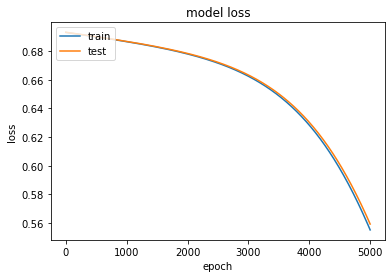

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
dataset[0]
latent=encoder.predict(np.array([dftrain[0]]).reshape(-1))
#latent=encoder.predict(np.array([dftrain[0]]))

ValueError: in user code:

    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1007 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:993 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/pro/miniforge3/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_10 is incompatible with the layer: expected axis -1 of input shape to have value 690 but received input with shape (None, 1)


In [70]:
np.array([[dftrain[0]]])

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0